In [1]:
from ast import literal_eval

import numpy as np
import corner

import matplotlib.pyplot as plt
pltparams = {"axes.grid": False,
        "text.usetex" : True,
        "font.family" : "serif",
        "ytick.color" : "black",
        "xtick.color" : "black",
        "axes.labelcolor" : "black",
        "axes.edgecolor" : "black",
        "font.serif" : ["Computer Modern Serif"],
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "axes.labelsize": 16,
        "legend.fontsize": 16,
        "legend.title_fontsize": 16,
        "figure.titlesize": 16,
        "figure.constrained_layout.use": False}

plt.rcParams.update(pltparams)

default_corner_kwargs = dict(bins=40, 
                        smooth=True, 
                        label_kwargs=dict(fontsize=16),
                        title_kwargs=dict(fontsize=16), 
                        quantiles=[],
                        levels=[0.68, 0.95],
                        plot_density=False, 
                        plot_datapoints=False, 
                        fill_contours=False,
                        max_n_ticks=3, 
                        min_n_ticks=3,
                        save=False,
                        truth_color="darkorange")

import pandas as pd

from fiesta.plot import corner_plot, LightcurvePlotter
from fiesta.inference.lightcurve_model import AfterglowFlux
from fiesta.inference.likelihood import EMLikelihood
from fiesta.utils import load_event_data


## Systematic uncertainty variable

Load the data

In [2]:
data = load_event_data("./data/injection_afterglowpy_gaussian.dat")
trigger_time = 58849

with open("./data/param_dict.dat", "r") as f:
    params = f.read()
params = literal_eval(params)

var_names = ["inclination_EM", "log10_E0", "thetaCore", "alphaWing", "log10_n0", "p", "log10_epsilon_e", "log10_epsilon_B", "sys_err"]


posterior_nmma = pd.read_csv("./outdir_nmma/injection_gaussian_posterior_samples.dat", sep=" ", header=0)
posterior_fiesta_arr = np.load("./outdir_fiesta/results_production.npz")
posterior_fiesta = pd.DataFrame(posterior_fiesta_arr["chains"].reshape(-1, 9), columns = var_names)
posterior_fiesta["log_prob"] = posterior_fiesta_arr["log_prob"].reshape(-1)
posterior_fiesta["redshift"] = np.zeros_like(posterior_fiesta_arr["log_prob"].reshape(-1))
posterior_fiesta["luminosity_distance"] = np.full_like(posterior_fiesta_arr["log_prob"].reshape(-1), 40)


posterior_nmma_x_fiesta = pd.read_csv("./outdir_nmma_x_fiesta/injection_gaussian_posterior_samples.dat", sep=" ", header=0)
posterior_nmma_x_fiesta["sys_err"] = posterior_nmma_x_fiesta["em_syserr"]

In [3]:
model = AfterglowFlux("afgpy_gaussian_CVAE",
                      filters = data.keys())

14:46 fiesta INFO    : Loading surrogate afgpy_gaussian_CVAE. This surrogate should only be used in the following parameter ranges:
14:46 fiesta INFO    : 	 inclination_EM: (0, 1.5707963267948966)
14:46 fiesta INFO    : 	 log10_E0: (47, 57)
14:46 fiesta INFO    : 	 thetaCore: (0.01, 0.6283185307179586)
14:46 fiesta INFO    : 	 alphaWing: (0.2, 3.5)
14:46 fiesta INFO    : 	 log10_n0: (-6, 2)
14:46 fiesta INFO    : 	 p: (2.01, 3)
14:46 fiesta INFO    : 	 log10_epsilon_e: (-4, 0)
14:46 fiesta INFO    : 	 log10_epsilon_B: (-8, 0)
14:46 fiesta INFO    : Surrogate afgpy_gaussian_CVAE is loading with the following filters: ['X-ray-5keV', 'besselli', 'bessellv', 'radio-6GHz', 'uvot::b'].
14:46 fiesta INFO    : Loaded for surrogate afgpy_gaussian_CVAE from /nfs/aya/work/hkoehn/fiesta/fiesta/src/fiesta/surrogates/GRB/afgpy_gaussian_CVAE/model.


Make corner plot

In [4]:

var_names = ["inclination_EM", "log10_E0", "thetaCore", "alphaWing", "log10_n0", "p", "log10_epsilon_e", "log10_epsilon_B", "sys_err"]
truths = [params[key] for key in var_names[:-1]]
truths.append(None)

likelihood = EMLikelihood(model=model,
                          data=data,
                          trigger_time=trigger_time,
                          tmin=0.01,
                          tmax=200.)

lc_plotter = LightcurvePlotter(posterior_fiesta,
                  likelihood,
                  free_syserr=True)

best_fit_mags_nmma = pd.read_csv("./figures/nmma_afgpy_best_fit_mags.dat", sep=" ")

14:46 fiesta INFO    : Loading and preprocessing observations in likelihood . . .
14:46 fiesta INFO    : No detection limit is given. Putting it to infinity.
14:46 fiesta INFO    : Loading and preprocessing observations in likelihood . . . DONE


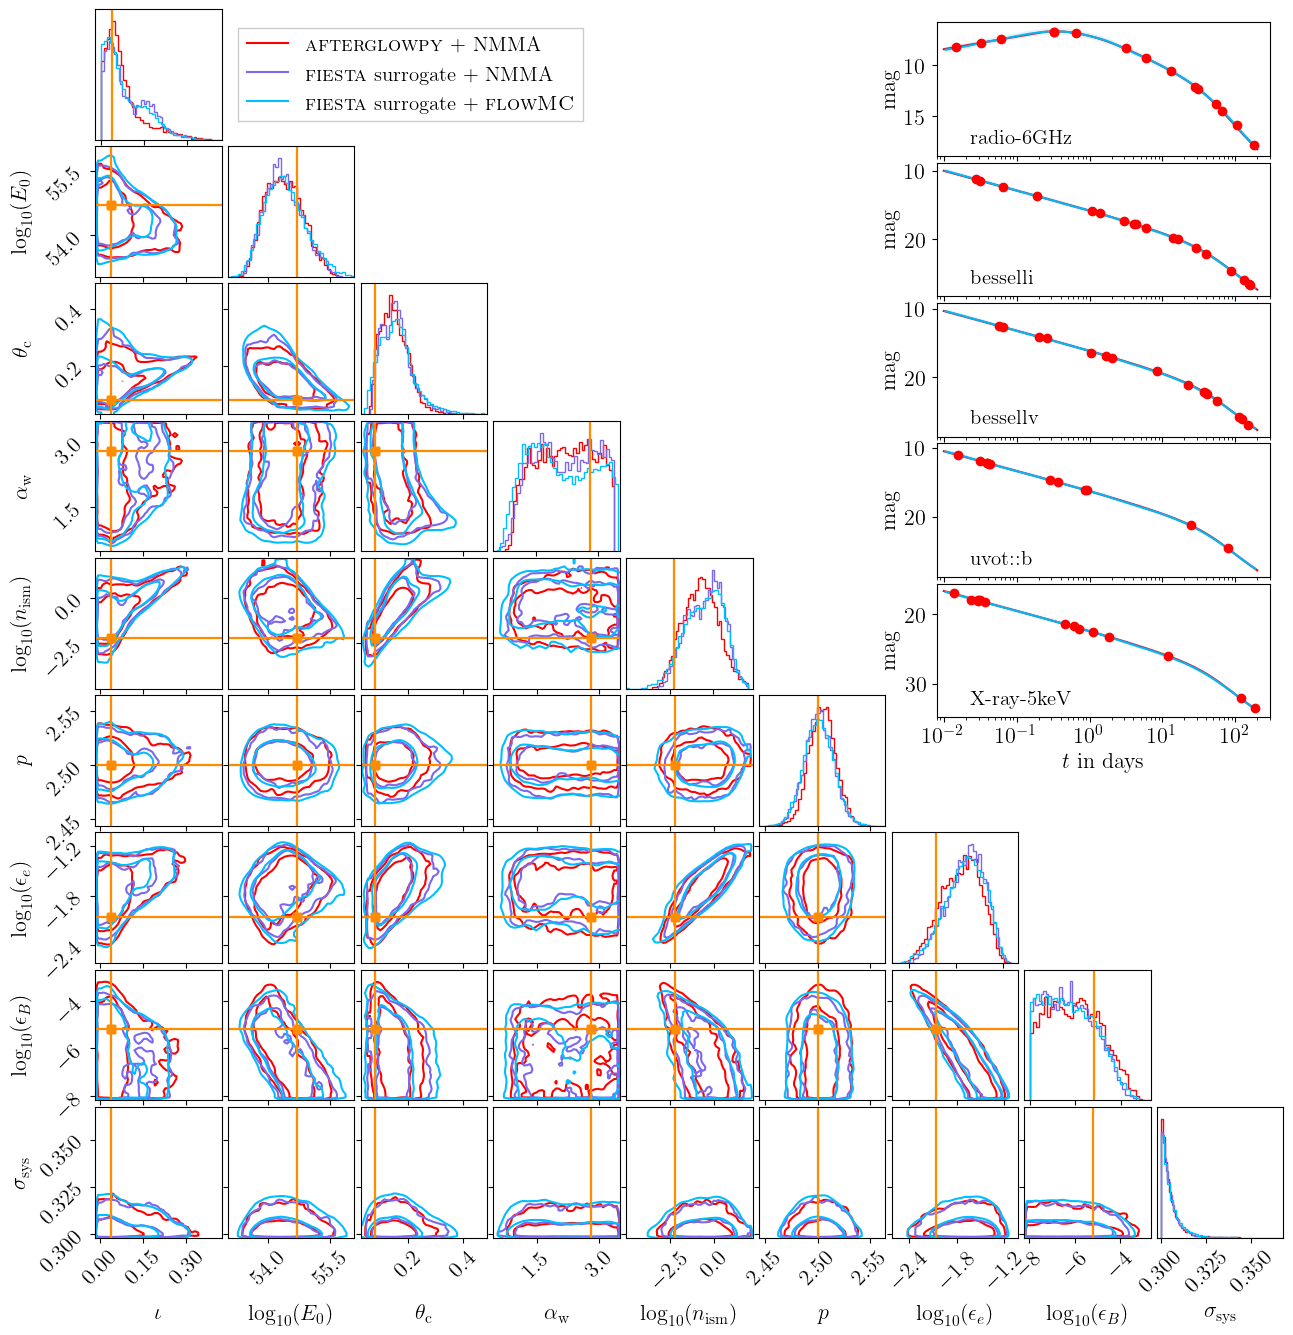

In [6]:

fig, ax = corner_plot(posterior_nmma, parameter_names=var_names, truths=params, color="red")
fig, ax = corner_plot(posterior_nmma_x_fiesta, parameter_names=var_names, truths=params, color="mediumslateblue", fig=fig, ax=ax)
fig, ax = corner_plot(posterior_fiesta, parameter_names=var_names, truths=params, color="deepskyblue", fig=fig, ax=ax)

def plot_lcs(j, filt):

    for k in range(6, 9):
        fig.delaxes(ax[j, k])

    pos1 = ax[j, 6].get_position()
    pos2 = ax[j, 8].get_position()

    x0 = pos1.x0+0.03
    y0 = pos1.y0
    width = pos2.x1 - x0
    height = pos1.height  # same height as original row

    ax_merged = fig.add_axes([x0, y0, width-0.03, height])

    ax_merged.plot(np.geomspace(1e-2, 200, 100), best_fit_mags_nmma[filt.replace("::","__")], color="red")
    lc_plotter.plot_data(ax_merged, filt, color="red")
    lc_plotter.plot_best_fit_lc(ax_merged, filt, color="deepskyblue")
    lc_plotter.plot_sys_uncertainty_band(ax_merged, filt)

    ax_merged.set_xscale("log")
    ax_merged.set_xlim(0.008, 300)

    ax_merged.invert_yaxis()
    ax_merged.set_ylabel("mag")
    ax_merged.text(0.1, 0.1, filt, transform=ax_merged.transAxes, fontsize=15)
    
    if j!=4:
        ax_merged.set_xticklabels([])

    if j==4:
        ax_merged.set_xlabel("$t$ in days")



plot_lcs(0, "radio-6GHz")
plot_lcs(1, "besselli")
plot_lcs(2, "bessellv")
plot_lcs(3, "uvot::b")
plot_lcs(4, "X-ray-5keV")


handles = []
for c in ["red", "mediumslateblue", "deepskyblue"]:
    handle = plt.plot([],[], color=c)[0]
    handles.append(handle)

ax[0, 1].legend(handles=handles, labels=["\\textsc{afterglowpy} + NMMA", "\\textsc{fiesta} surrogate + NMMA", "\\textsc{fiesta} surrogate + \\textsc{flowMC}"], fontsize=15, fancybox=False, framealpha=1, loc="center left")
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.96, top=0.99)

fig.savefig("./figures/injection_afgpy_gaussian.pdf", dpi=250, bbox_inches="tight")
plt.show()

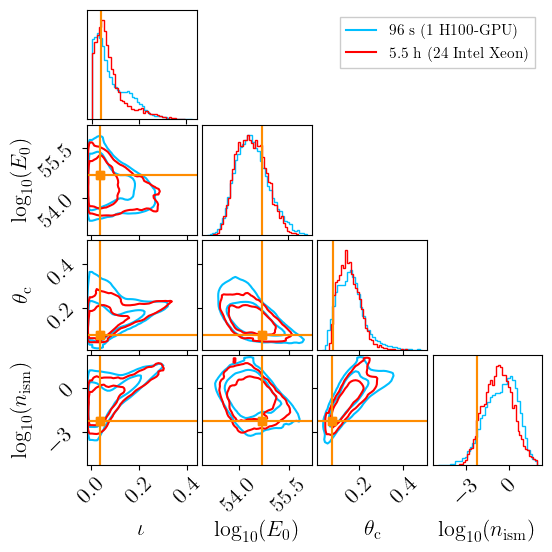

In [21]:
var_names = ["inclination_EM", "log10_E0", "thetaCore", "log10_n0"]

fig, ax = corner_plot(posterior_fiesta, parameter_names=var_names, truths=params, color="deepskyblue")
fig, ax = corner_plot(posterior_nmma, parameter_names=var_names, truths=params, color="red", fig=fig, ax=ax)

handles = []
for c in ["deepskyblue", "red"]:
    handle = plt.plot([],[], color=c)[0]
    handles.append(handle)

ax[0, -1].legend(handles=handles, labels=["96 s (1 H100-GPU)", "5.5 h (24 Intel Xeon)"], fontsize=11, fancybox=False, framealpha=1)
fig.subplots_adjust(bottom=0.2, left=0.2)
fig.savefig("./figures/small_corner.pdf", dpi=250)